In [919]:
# reload magics
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [920]:
import colorcet as cc
import logging
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from copy import deepcopy


palette = cc.glasbey_hv

# create a palette dictionary that has the same keys as the original palette
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')


In [921]:
# heatmap parms
heatmap_parms = {
    'cbar': False,
    'square': False,
    'linewidths': 0.5,
    'linecolor': 'black',
    'center': 0.0,
    'vmin': -1,
    'vmax': 1,
    'annot': True,
    'fmt': '.2f',
}



In [922]:
figdir = "./OUTPUT/lc-pos-figures"

## FUNCTIONS

In [964]:
#===============================================================================
def make_centroids(e, lbls):
#===============================================================================

    # assume that lbls is a pandas series
    if isinstance(lbls, pd.Series):
        lbls = lbls.values
    


    # get the centroids of the umap coordinates by cluster
    centroids = pd.DataFrame(e, 
                                columns = ["x", "y"]).assign(cluster = lbls).groupby("cluster").mean()
    return centroids


#===============================================================================
def make_plot_df(embeddings, clusterer, index, sites):
#===============================================================================

    d = pd.DataFrame(embeddings, columns = ["x", "y"], index = index)
    d["Cluster"]             = clusterer.labels_
    d["Cluster Confidence"]  = clusterer.probabilities_
    d["Most Likely Cluster"] = np.argmax(all_points_membership_vectors(clusterer), axis = 1)
    d["Site"]                = sites


    return d



In [966]:
#===============================================================================
def plot_clusters(df, centroids, title = None):
#===============================================================================

    # plot the embeddings
    fig, ax = plt.subplots(figsize=(10, 10))

    sns.scatterplot(data = df, 
                    x = "x",
                    y = "y",
                    s = 50,
                    edgecolor = 'black', 
                    hue       = "Most Likely Cluster",
                    linewidth = 0.5, 
                    palette   = palette_dict,
                    style     = "Site",
                    size      = "Cluster Confidence",
                    ax = ax
                        )

    # plot centroids
    plot_centroids(centroids, ax)

    # set title
    if title:
        plt.title(title)

    # place the legend outside to the right of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # turn off axis labels and ticks
    plt.xticks([]); plt.yticks([]);
    plt.xlabel(""); plt.ylabel("");


#===============================================================================
def plot_centroids(centroids, ax):
#===============================================================================
    # plot the centroids
    for i, centroid in centroids.iterrows():
        if i != -1:

            ax.annotate(
                        i,
                        (centroid.x, centroid.y), 
                        ha='center',
                        va='center',
                        bbox=dict(boxstyle="round,pad=0.3", 
                                    fc="white", 
                                    ec="black",
                                    lw=1, 
                                    # alpha=0.75
                                    )
                        )



## LOAD DATA

In [925]:
# load the data from the xlsx file
# df = pd.read_excel('../lc-project-data/features.xlsx')

In [926]:
# datasets are way faster than excel files
from datasets.arrow_dataset import Dataset

# load the dataset from disk
ds = Dataset.load_from_disk('../lc-project-data/features.arrow')
ds

Dataset({
    features: ['sex', 'age', 'dag', 'MED-Analgesics', 'MED-Anesthetics', 'MED-Antibacterials', 'MED-Anticonvulsants', 'MED-Antidepressants\xa0', 'MED-Antifungals', 'MED-Antimigraine-agents', 'MED-Antiparasitics', 'MED-Antiparkinson-agents', 'MED-Antipsychotics', 'MED-Antispasticity-agents', 'MED-Antivirals', 'MED-Blood-glucose-regulators', 'MED-Blood-products', 'MED-Cardiovascular-agents', 'MED-Dermatological-agents', 'MED-Gastrointestinal-agents', 'MED-Hormonal-agents-(adrenal)', 'MED-Hormonal-agents-(sex-hormones)', 'MED-Hormonal-agents-(thyroid)', 'MED-Hormone-suppressant-(thyroid)', 'MED-Immunological-agents', 'MED-Inflammatory-bowel-disease-agents', 'MED-Metabolic-bone-disease-agents', 'MED-Ophthalmic-agents', 'MED-Respiratory-tract-agents', 'MED-Skeletal-muscle-relaxants', 'SYMPT-abdominal_pain___1', 'SYMPT-abdominal_pain___2', 'SYMPT-chest_pain___1', 'SYMPT-chest_pain___2', 'SYMPT-confusion_altered_mental_s___1', 'SYMPT-confusion_altered_mental_s___2', 'SYMPT-cough___1

In [927]:
# convert to pandas dataframe
df = ds.to_pandas()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5802 entries, 0 to 5801
Columns: 420 entries, sex to LC_STATUS
dtypes: float64(366), int64(53), object(1)
memory usage: 18.6+ MB


## LC+, LC-, HC

In [928]:
LC_pos = df.query('LC_STATUS == "LC_POS"')
LC_neg = df.query('LC_STATUS == "LC_NEG"')
HC = df.query('LC_STATUS == "HC"')


In [929]:
LC_pos.shape, LC_neg.shape, HC.shape

((2461, 420), (3260, 420), (81, 420))

In [930]:
# drop object columns because we don't need this 
try:
    LC_pos = LC_pos.drop(columns=['LC_STATUS'])
except:
    pass


## SITES

In [931]:
site_name_dict = {1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                    4: 'RIO',
                    5: 'LUS',
}

In [932]:
# map dag using site_name_dict
LC_pos['SITE'] = LC_pos['dag'].map(site_name_dict)

In [933]:
# get the range of indices for each site
site_ranges = LC_pos.groupby('SITE').apply(lambda x: (x.index.min(), x.index.max())).rename(index = site_name_dict) # type: ignore

site_ranges.sort_values()

SITE
MTL       (0, 1764)
RIO    (2913, 3571)
LUS    (3709, 5146)
SAN    (5180, 5406)
LDN    (5500, 5801)
dtype: object

In [934]:
# drop RIO and LUS
# LC_pos = LC_pos.query('SITE != "RIO" and SITE != "LUS"')
# LC_pos = LC_pos.query(' SITE != "LUS"')
LC_pos['SITE'].value_counts()

SITE
MTL    916
RIO    659
LUS    549
SAN    227
LDN    110
Name: count, dtype: int64

In [935]:
# get the range of indices for each site
site_ranges = LC_pos.groupby('SITE').apply(lambda x: (x.index.min(), x.index.max())).rename(index = site_name_dict) # type: ignore

site_ranges.sort_values()

SITE
MTL       (0, 1764)
RIO    (2913, 3571)
LUS    (3709, 5146)
SAN    (5180, 5406)
LDN    (5500, 5801)
dtype: object

# CLUSTERING

In [936]:
# clustering
from sklearn.preprocessing import MinMaxScaler

# dim reduction and clustering benefit from scaling
scaler = MinMaxScaler().set_output(transform = "pandas")

In [937]:
# a new dataframe, in case we need to manipulate it and retain the original
LC_pos_ = LC_pos

# drop certain columns, to experiment with effect on clustering
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'LABS').columns)

# based on experiments, MED and CD do almost nothing for clustering, so we drop them
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'MED').columns)

print(LC_pos_.shape)

(2461, 115)


In [938]:
# drop the dag and SITE columns - these might guide the clustering algorithm to cluster by site

X = scaler.fit_transform(LC_pos_.drop(columns=['dag', 'SITE'])) 

# the clustering algorithms depend on the data being complete
# if we drop NAs, then there are only 3 records from LUS left
# X = X.dropna()
# if we fill with zeroes, then we are assuming that the missing values are zero
X.fillna(0, inplace = True)

# a reference copy of the data, for later use in other clustering algorithms
X_ref = deepcopy(X)
print(X.shape, X_ref.shape)

(2461, 113) (2461, 113)


## Use UMAP to visualize the data and cluster

In [939]:
from hdbscan import HDBSCAN, approximate_predict, all_points_membership_vectors
from umap import UMAP

hdb_parms = {
                # min_cluster_size is rouglhy 
                # sqrt(n) where n is the number of samples
                'min_cluster_size': 50, 
                'prediction_data': True,
                'cluster_selection_method': 'leaf',
                # 'cluster_selection_epsilon': 0.5,
                # 'min_samples': 50,
            }

umap_parms = {
                'n_components': 2,
                'spread':       5.0,
                'random_state': 42,
            }


# instantiate the clustering and dim reduction objects
hdb_umap   = HDBSCAN(**hdb_parms)
umap_      = UMAP(**umap_parms)

In [940]:
# always use the reference data for clustering
X = deepcopy(X_ref)

# dimension reduction
umap_embeddings = umap_.fit_transform(X)

# clustering on the reduced data
hdb_umap.fit(umap_embeddings)
# get the cluster vectors
cvec = all_points_membership_vectors(hdb_umap)
# cluster labels are the maximally probable cluster
cluster_labels = np.argmax(cvec, axis = 1)

print(f"Found {len(np.unique(cluster_labels))} clusters")

/Users/david/mambaforge/envs/lm2/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/Users/david/mambaforge/envs/lm2/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Found 10 clusters


In [941]:
# # make a plotting dataframe
sites = LC_pos_["dag"].map(site_name_dict)
plot_df = make_plot_df(umap_embeddings, hdb_umap, X_ref.index, sites)

# get the centroids of the umap coordinates by cluster
umap_centroids = make_centroids(umap_embeddings, cluster_labels)

In [942]:
# # make a list of colours, desaturated by the probability of the cluster
plot_df["colour"] = plot_df["Cluster"].map(palette_dict)
plot_df["colour"] = plot_df["colour"].apply(lambda x: mc.to_rgba(x, alpha = 0.5))

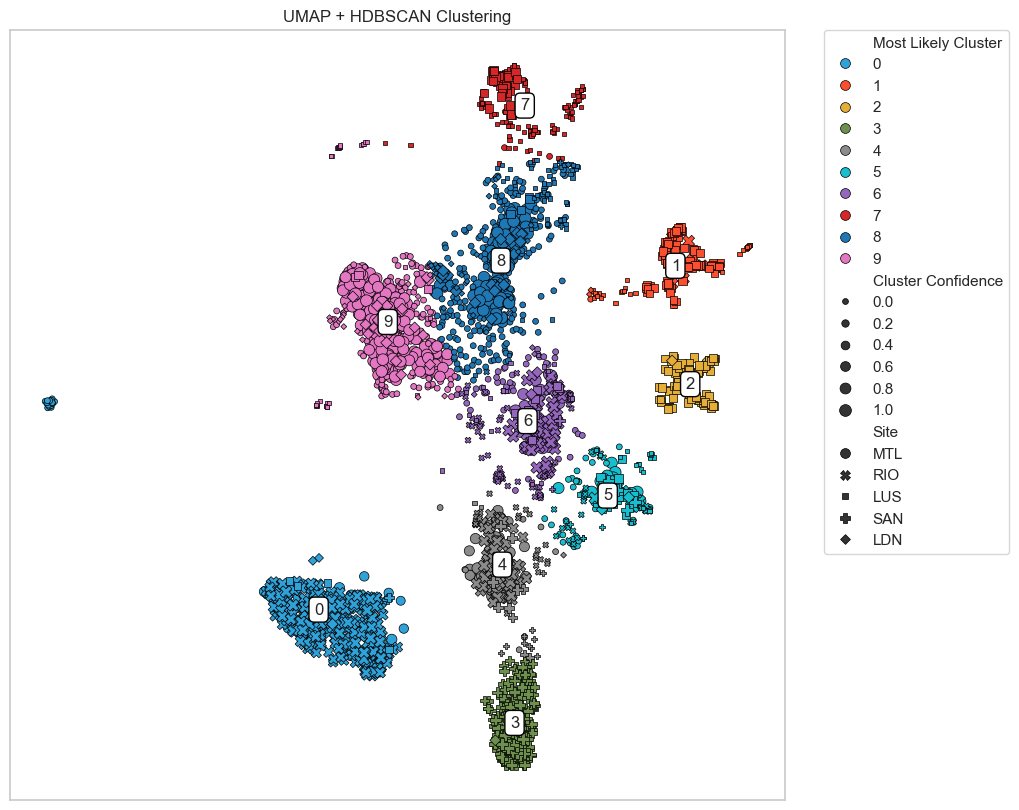

In [967]:
plot_clusters(plot_df, umap_centroids, title = "UMAP + HDBSCAN Clustering")

fn = "clusters-umap.png"
p = f"{figdir}/{fn}"

plt.savefig(p, dpi = 300, bbox_inches = 'tight')

In [968]:
# # another way - cluster first in high-dim space, then reduce to 2D

# # cluster
# hdb_.fit(X)

# # get the cluster vectors
# cvec = all_points_membership_vectors(hdb_)

# # cluster labels are the maximally probable cluster
# cluster_labels = np.argmax(cvec, axis = 1)
# # umap
# X_umap = umap_.fit_transform(X, y = cluster_labels)
# # X_umap = umap_.fit_transform(X, )
# # X_umap = umap_.fit_transform(X, y = LC_pos["dag"])

# dplot2 = pd.DataFrame(X_umap, columns = ["x", "y"], index = X.index)
# dplot2["cluster"] = cluster_labels
# dplot2["Site"] = LC_pos_["dag"].map(site_name_dict)

# # plot the clusters
# fig, ax = plt.subplots(figsize=(10, 10))
# sns.scatterplot(data = dplot2, x="x", y = "y", hue="cluster", s=50, palette = palette,  edgecolor='black', linewidth=0.5, ax = ax, style = "Site",)
# # make marker size larger
# plt.legend(markerscale=1)

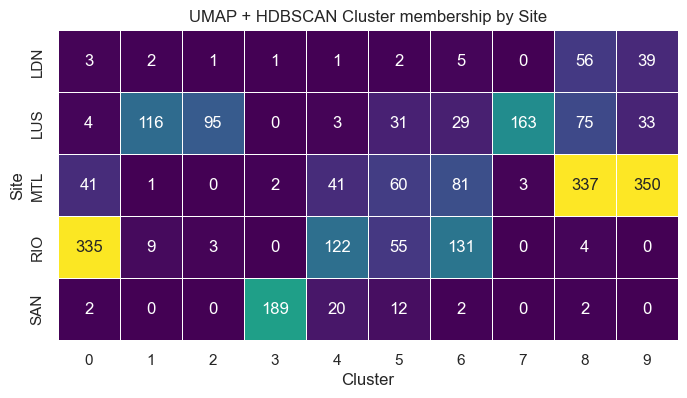

In [969]:
# augment the LCPOS with the cluster labels
LC_pos_.loc[X.index, "cluster"] = plot_df["Most Likely Cluster"]

cluster_by_site = LC_pos_.groupby("cluster")["SITE"].value_counts().unstack().T
cluster_by_site = cluster_by_site.fillna(0).astype(int)
cluster_by_site.columns = cluster_by_site.columns.astype(int)

fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(cluster_by_site, robust = True, ax = ax, annot = True, fmt = "d", cmap = "viridis", square = True, linewidths = 0.5, linecolor = "w", cbar = False)

# rename axis labels
plt.xlabel("Cluster")
plt.ylabel("Site")

plt.title("UMAP + HDBSCAN Cluster membership by Site")

fn = "cluster-membership-umap.png"
p = f"{figdir}/{fn}"

plt.savefig(p, dpi = 300, bbox_inches = 'tight')


### Examine some of the clusters

In [970]:
# save the cluster labels to the original dataframe
# we add the cluster labels here, which is way the clusterers should always be fed X_ref (a clean, reference copy of the original dataframe)


X["cluster"] = cluster_labels

interesting = ["sex", "HHX-HIV or AIDS", "VAX-vaccinated"]

# get the means by cluster
X.groupby("cluster")[interesting].mean()



,sex,HHX-HIV or AIDS,VAX-vaccinated
cluster,,,
0,0.561201,0.000000,0.942263
1,0.701923,0.000000,0.956731
2,0.015385,0.161538,0.023077
3,0.968254,0.238095,0.079365
4,0.556000,0.144000,0.328000
5,0.073059,0.036530,0.986301
6,0.787037,0.003086,0.981481
7,0.747596,0.002404,0.971154
8,0.467606,0.014085,0.923944


In [971]:
# how many HIV or AIDS in each cluster?
X.groupby("cluster")["HHX-HIV or AIDS"].value_counts(normalize = False).unstack().fillna(0)

HHX-HIV or AIDS,0.0,1.0
cluster,,
0,433.0,0.0
1,208.0,0.0
2,109.0,21.0
3,96.0,30.0
4,214.0,36.0
5,211.0,8.0
6,323.0,1.0
7,415.0,1.0
8,350.0,5.0


In [972]:
# how many HIV or AIDS in the original dataset?
LC_pos["HHX-HIV or AIDS"].value_counts(normalize = False)

HHX-HIV or AIDS
0.0    1834
1.0     102
Name: count, dtype: int64

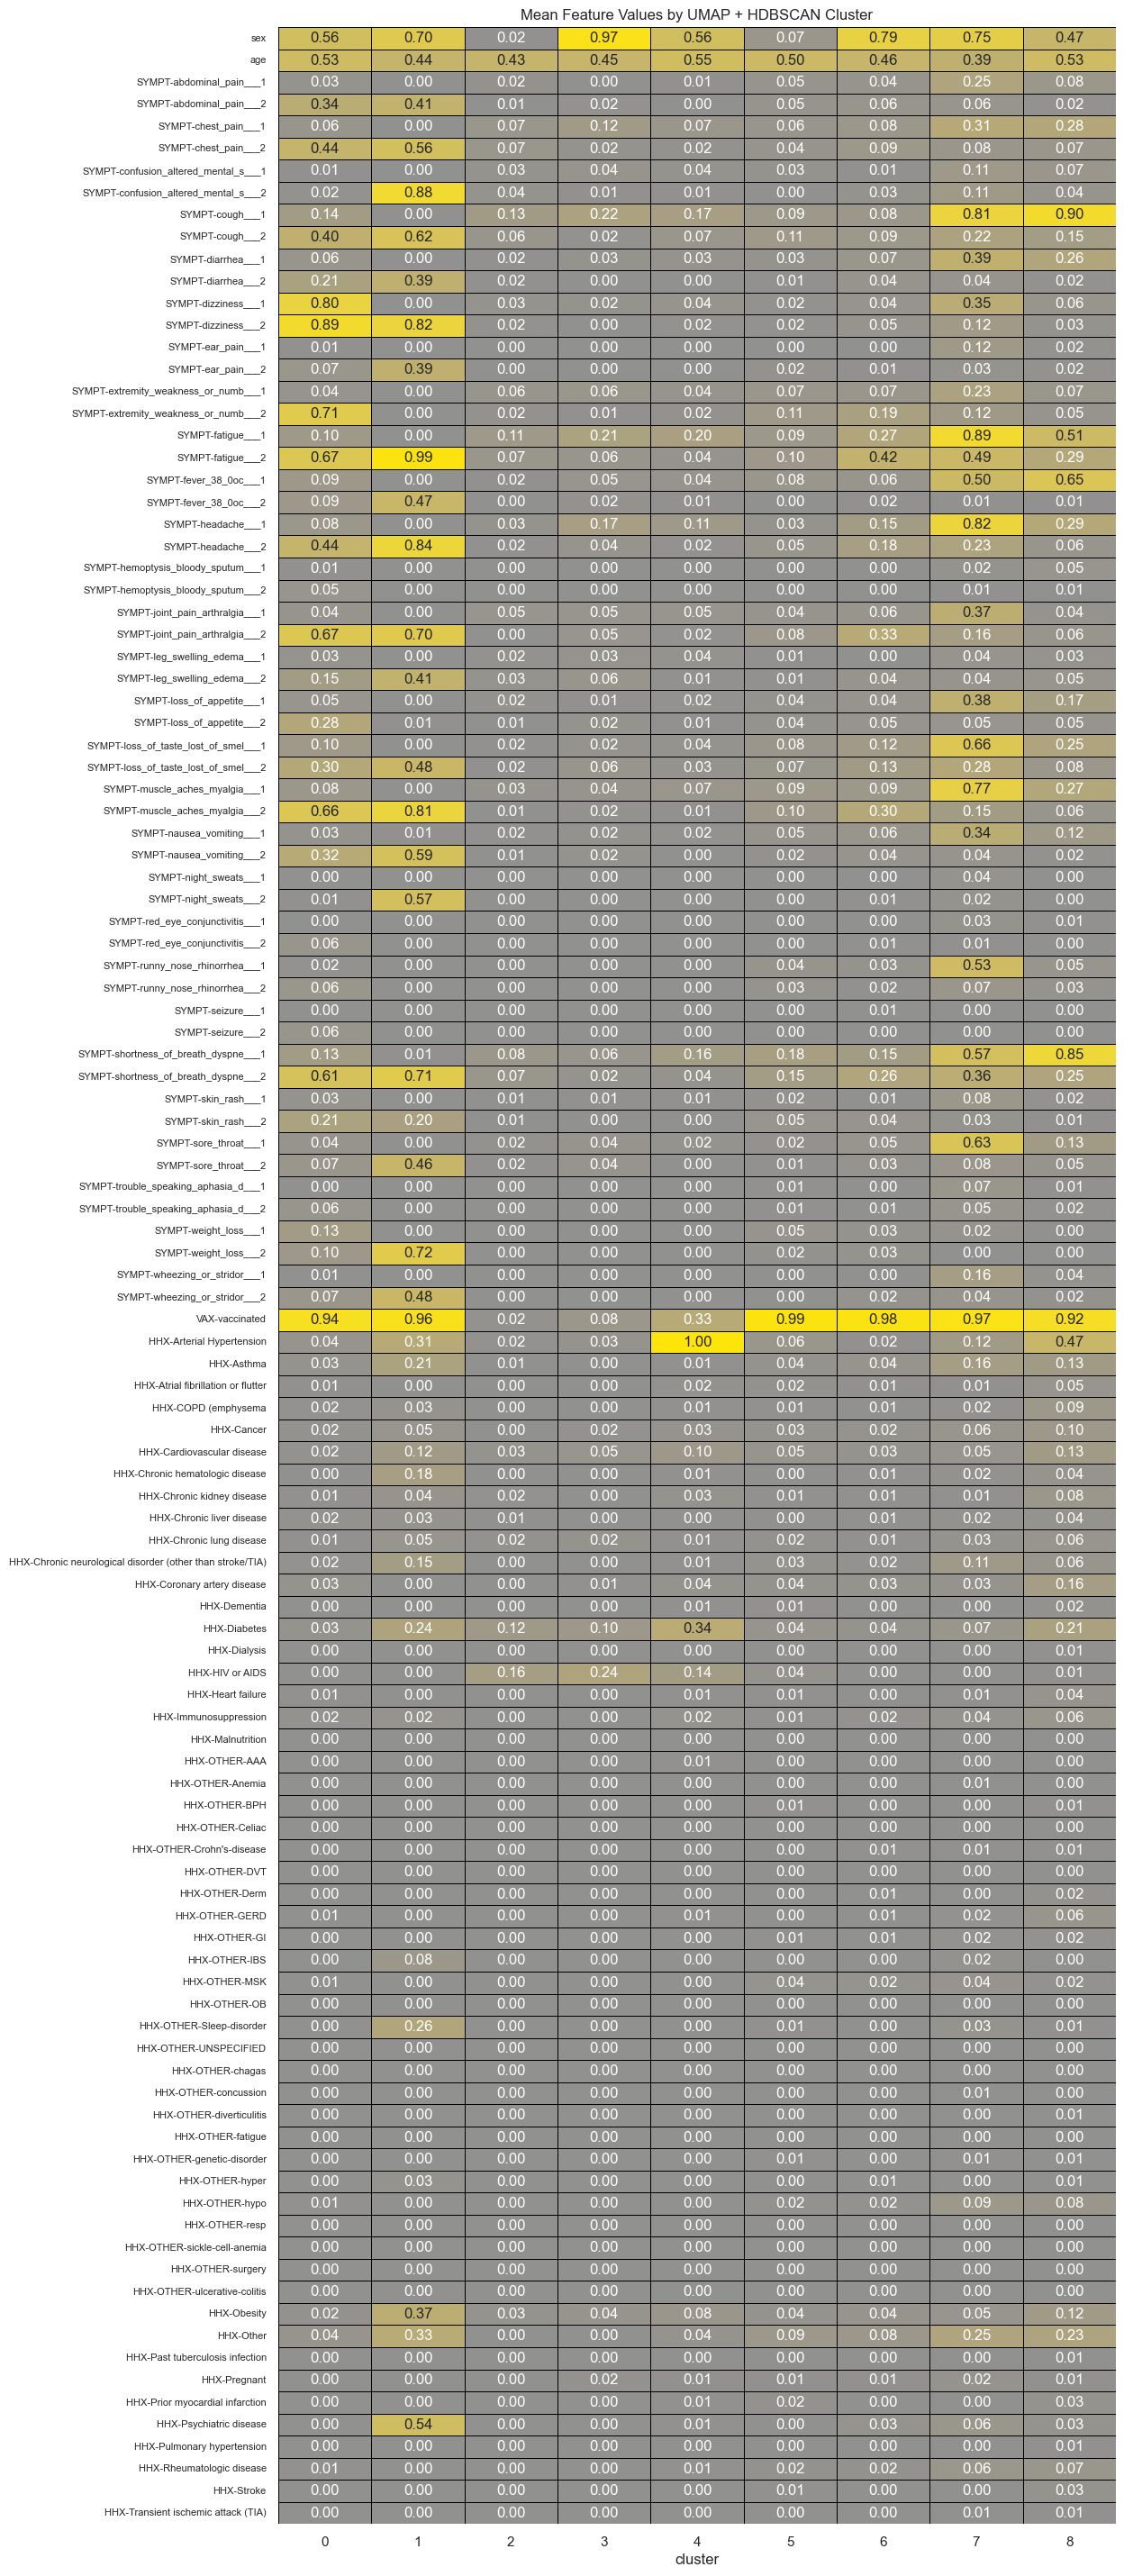

In [973]:
# heatmap of the means by cluster
fig, ax = plt.subplots(figsize=(12,36))

# apply lognorm to the colour scale
norm = mc.LogNorm(vmin = 0.01, vmax = 10.0)
norm = None

# get the means by cluster

mm = X.groupby("cluster").mean().T

# negative log transform
# mm = -np.log10(mm)

# sort mm in alphabetical order
# mm = mm.sort_index()

# use a diverging colour scheme
cmap = sns.diverging_palette(220, 20, as_cmap = True)

cmap = cc.cm.bjy

sns.heatmap(mm, cmap = cmap, ax = ax, **heatmap_parms, norm = norm)

plt.title("Mean Feature Values by UMAP + HDBSCAN Cluster")
# make font smaller
plt.yticks(fontsize = 8);


fn = "mean-feature-values-umap.png"
p = f"{figdir}/{fn}"

plt.savefig(p, dpi = 300, bbox_inches = 'tight')

In [974]:
# group by cluster and count the number of records
cluster_counts = X.groupby("cluster")

# pivot table for counts of specific symptoms
symptom_counts = X.groupby("cluster").sum()/cluster_counts.count()*100
symptom_counts[["HHX-HIV or AIDS", "VAX-vaccinated"]]

,HHX-HIV or AIDS,VAX-vaccinated
cluster,,
0,0.000000,94.226328
1,0.000000,95.673077
2,16.153846,2.307692
3,23.809524,7.936508
4,14.400000,32.800000
5,3.652968,98.630137
6,0.308642,98.148148
7,0.240385,97.115385
8,1.408451,92.394366


In [975]:
# group LC_pos by site and get Psychiatric disease counts
LC_pos.groupby("SITE")["HHX-Psychiatric disease"].value_counts().unstack().fillna(0)


HHX-Psychiatric disease,0.0,1.0
SITE,,
LDN,26.0,10.0
LUS,3.0,2.0
MTL,878.0,37.0
RIO,659.0,0.0
SAN,111.0,116.0


In [976]:
# sns.clustermap(X.drop(["cluster"], axis = 1), row_cluster = False, col_cluster = True, cmap = "viridis")

## Use IVIS to visualize the data and cluster

In [977]:
# load ivis module
from ivis import Ivis

XX_ivis = deepcopy(np.array(X_ref))

ivis = Ivis(k = 150, verbose = 0)
ivis.fit(XX_ivis)
ivis_embeddings = ivis.transform(XX_ivis)

hdb_ivis = HDBSCAN(**hdb_parms)
hdb_ivis.fit(ivis_embeddings)

HDBSCAN(cluster_selection_method='leaf', min_cluster_size=50,
        prediction_data=True)

In [978]:
sites = LC_pos_["dag"].map(site_name_dict)
ivis_df        = make_plot_df(ivis_embeddings, hdb_ivis, X_ref.index, sites)
ivis_centroids = make_centroids(ivis_embeddings, ivis_df["Most Likely Cluster"])


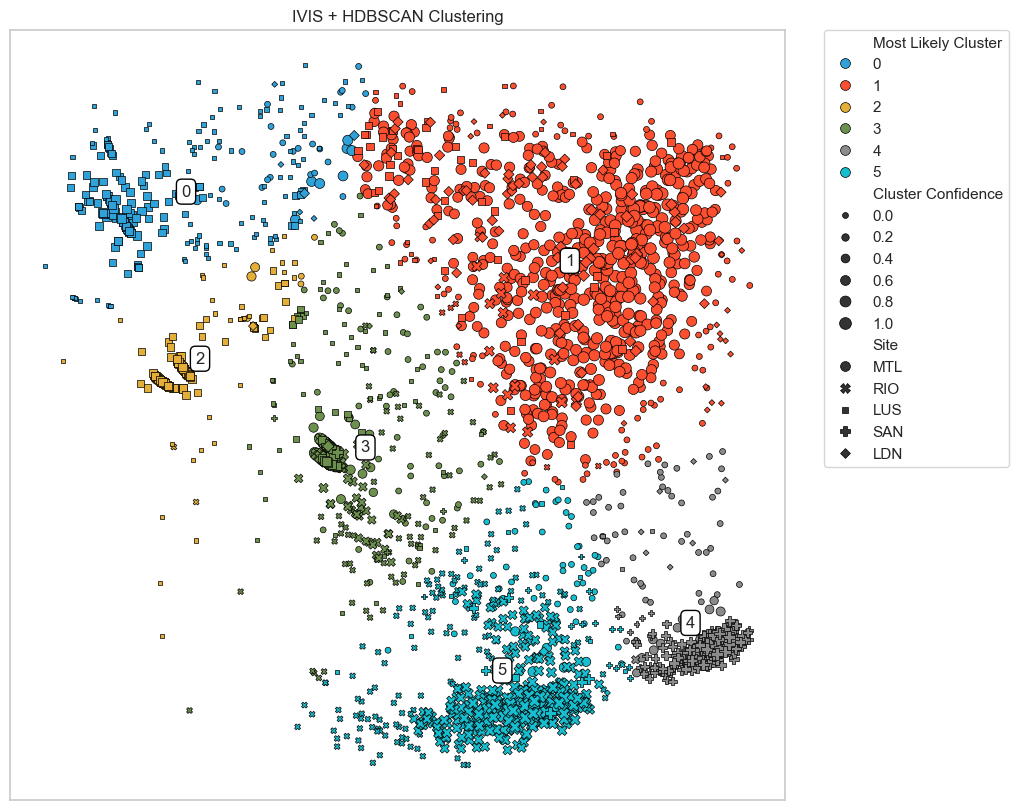

In [979]:
plot_clusters(ivis_df, ivis_centroids, title = "IVIS + HDBSCAN Clustering")

fn = "clusters-ivis.png"
p = f"{figdir}/{fn}"

plt.savefig(p, dpi = 300, bbox_inches = 'tight')


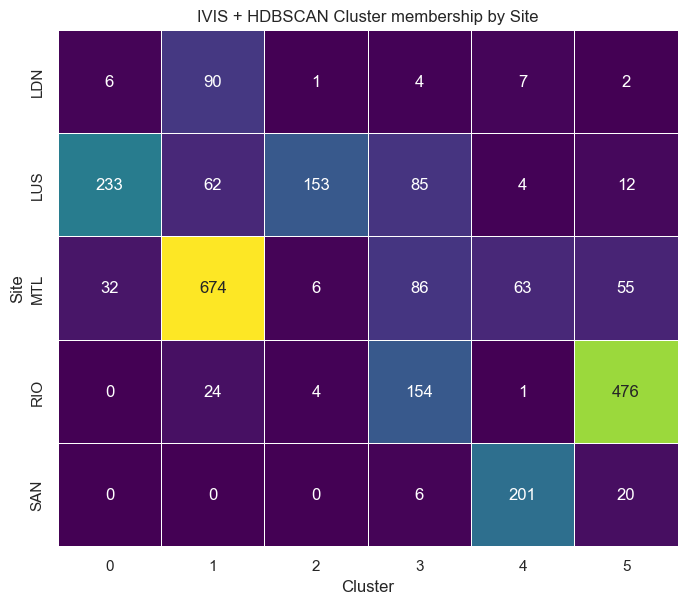

In [980]:
cluster_labels = ivis_df["Most Likely Cluster"]

LC_pos_.loc[X_ref.index, "cluster"] = cluster_labels

cluster_by_site = LC_pos_.groupby("cluster")["SITE"].value_counts().unstack().T
cluster_by_site = cluster_by_site.fillna(0).astype(int)
cluster_by_site.columns = cluster_by_site.columns.astype(int)

fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(cluster_by_site, 
                    robust = True, 
                    ax = ax, 
                    annot = True, 
                    fmt = "d", 
                    cmap = "viridis", 
                    square = True, 
                    linewidths = 0.5, 
                    linecolor = "w", 
                    cbar = False
                    )

# rename axis labels
plt.xlabel("Cluster")
plt.ylabel("Site")

plt.title("IVIS + HDBSCAN Cluster membership by Site")

fn = "cluster-membership-ivis.png"
p = f"{figdir}/{fn}"

plt.savefig(p, dpi = 300, bbox_inches = 'tight')


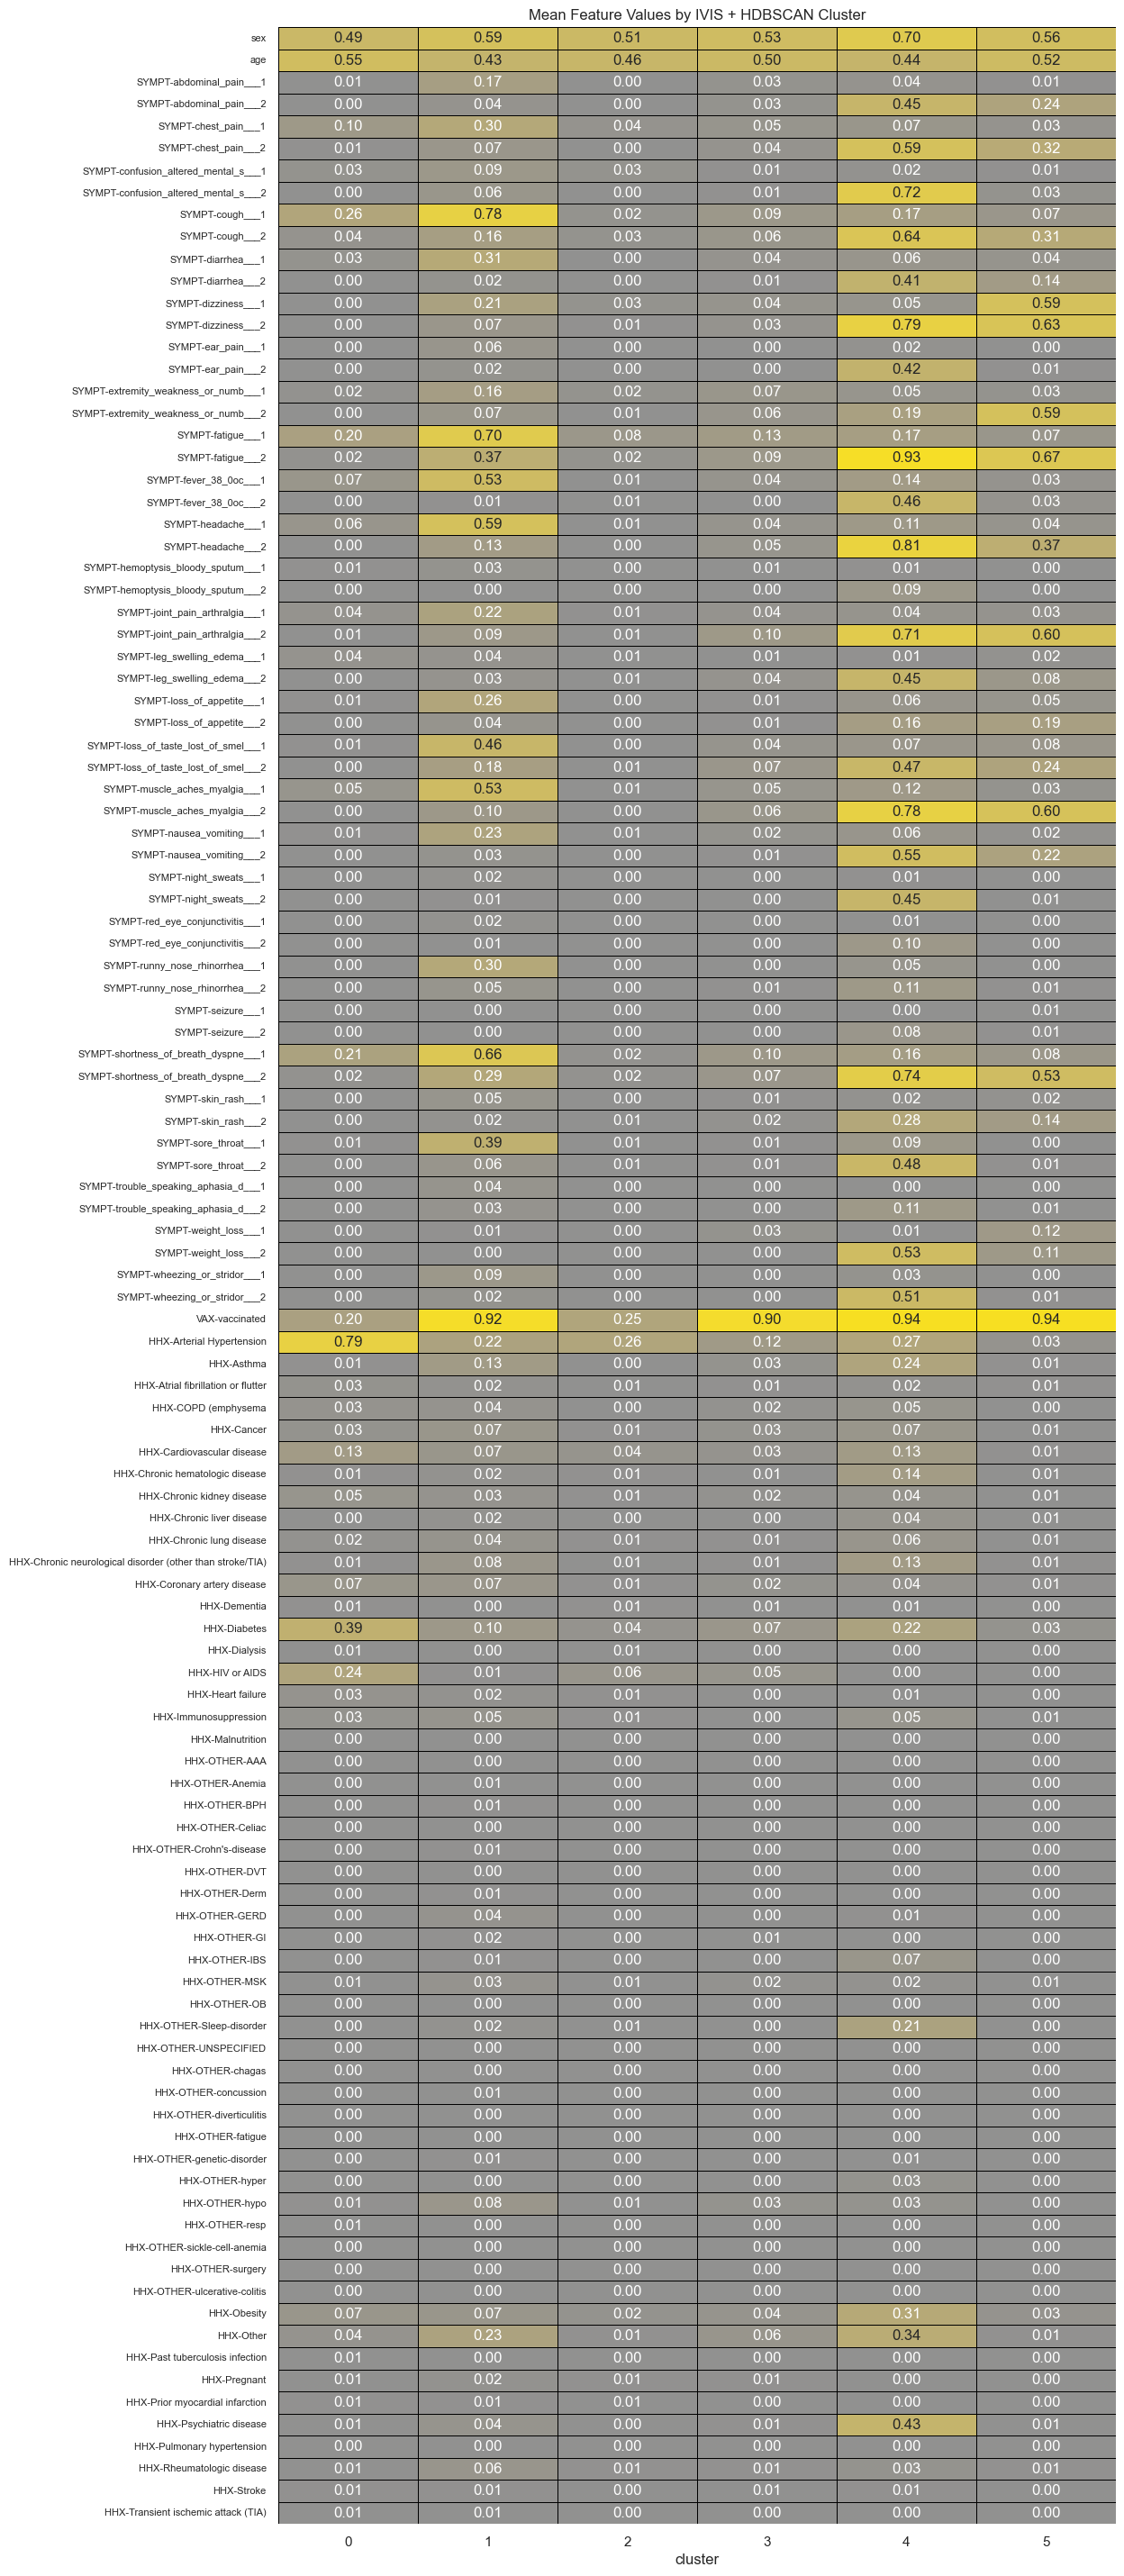

In [981]:
# heatmap of the means by cluster
fig, ax = plt.subplots(figsize=(12,36))

# apply lognorm to the colour scale
norm = mc.LogNorm(vmin = 0.01, vmax = 10.0)
norm = None

# get the means by cluster

XX = deepcopy(X_ref)

# augment with cluster
XX["cluster"] = ivis_df["Most Likely Cluster"]

mm = XX.groupby("cluster").mean().T

# negative log transform
# mm = -np.log10(mm)

# sort mm in alphabetical order
# mm = mm.sort_index()

# use a diverging colour scheme
cmap = sns.diverging_palette(220, 20, as_cmap = True)

cmap = cc.cm.bjy

sns.heatmap(mm, cmap = cmap, norm = norm, **heatmap_parms, ax = ax)

plt.title("Mean Feature Values by IVIS + HDBSCAN Cluster")
# make font smaller
plt.yticks(fontsize = 8);
# plt.savefig('mean_feature_values.png', dpi = 300)

fn = "mean-feature-values-ivis.png"
p = f"{figdir}/{fn}"

plt.savefig(p, dpi = 300, bbox_inches = 'tight')


## Use TSNE to visualize the data and cluster

In [982]:
# import TSNE from sklearn
from sklearn.manifold import TSNE

XX = deepcopy(X_ref)

tsne = TSNE(n_components = 2, perplexity = 30, random_state = 42)
tsne_embeddings = tsne.fit_transform(XX)
hdb_tsne = HDBSCAN(**hdb_parms)
hdb_tsne.fit(tsne_embeddings)


HDBSCAN(cluster_selection_method='leaf', min_cluster_size=50,
        prediction_data=True)

In [983]:
# data frame and centroids for plotting
sites = LC_pos_["dag"].map(site_name_dict)
tsne_df        = make_plot_df(tsne_embeddings, hdb_tsne, X_ref.index, sites)
tsne_centroids = make_centroids(tsne_embeddings, tsne_df["Most Likely Cluster"])


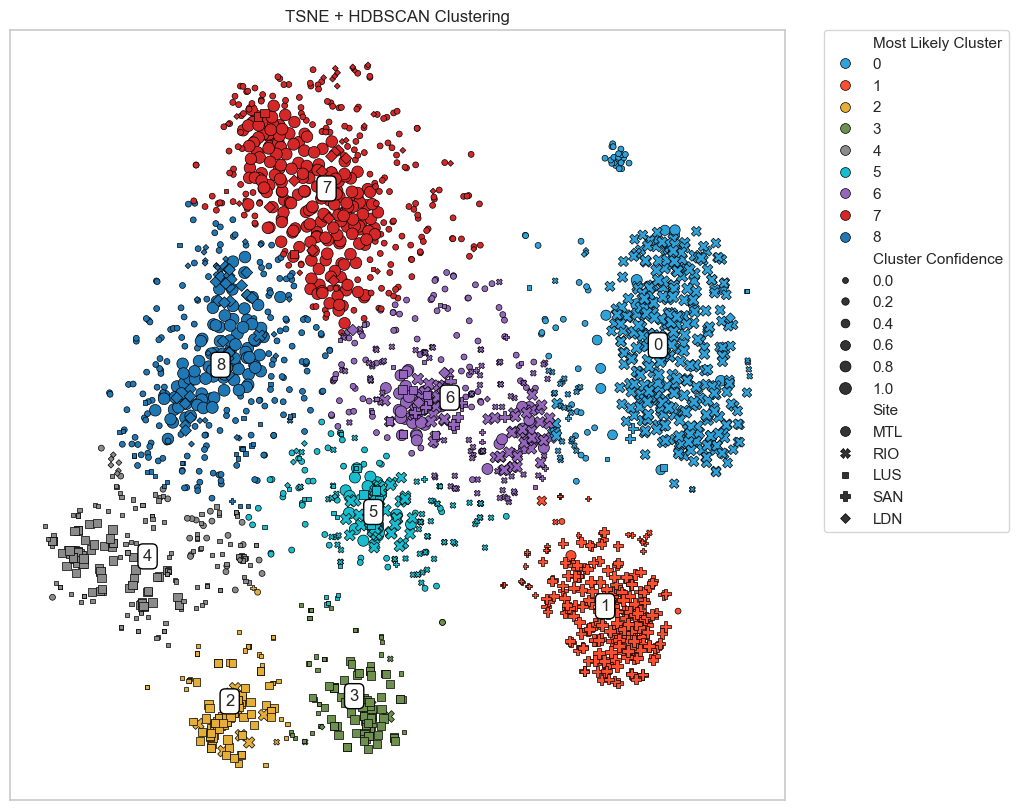

In [984]:
plot_clusters(tsne_df, tsne_centroids, title = "TSNE + HDBSCAN Clustering")

fn = "clusters-tsne.png"
p = f"{figdir}/{fn}"

plt.savefig(p, dpi = 300, bbox_inches = 'tight')


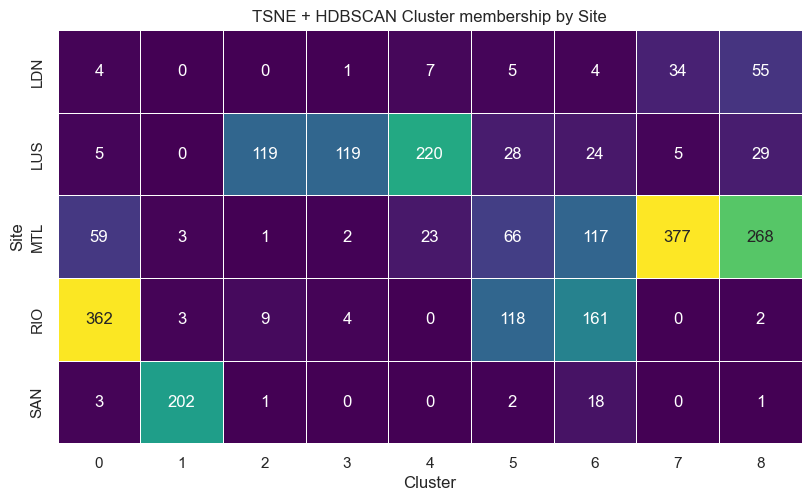

In [985]:
# augment the LCPOS with the cluster labels

cluster_labels = tsne_df["Most Likely Cluster"]

LC_pos_.loc[X.index, "cluster"] = cluster_labels

cluster_by_site = LC_pos_.groupby("cluster")["SITE"].value_counts().unstack().T
cluster_by_site = cluster_by_site.fillna(0).astype(int)
cluster_by_site.columns = cluster_by_site.columns.astype(int)

fig, ax = plt.subplots(figsize=(8,8), layout = "constrained")

sns.heatmap(cluster_by_site, 
                    robust = True, 
                    ax = ax, 
                    annot = True, 
                    fmt = "d", 
                    cmap = "viridis", 
                    square = True, 
                    linewidths = 0.5, 
                    linecolor = "w", 
                    cbar = False
                    )

# rename axis labels
plt.xlabel("Cluster")
plt.ylabel("Site")

plt.title("TSNE + HDBSCAN Cluster membership by Site")


fn = "cluster-membership-tsne.png"
p = f"{figdir}/{fn}"

plt.savefig(p, dpi = 300, bbox_inches = 'tight')    

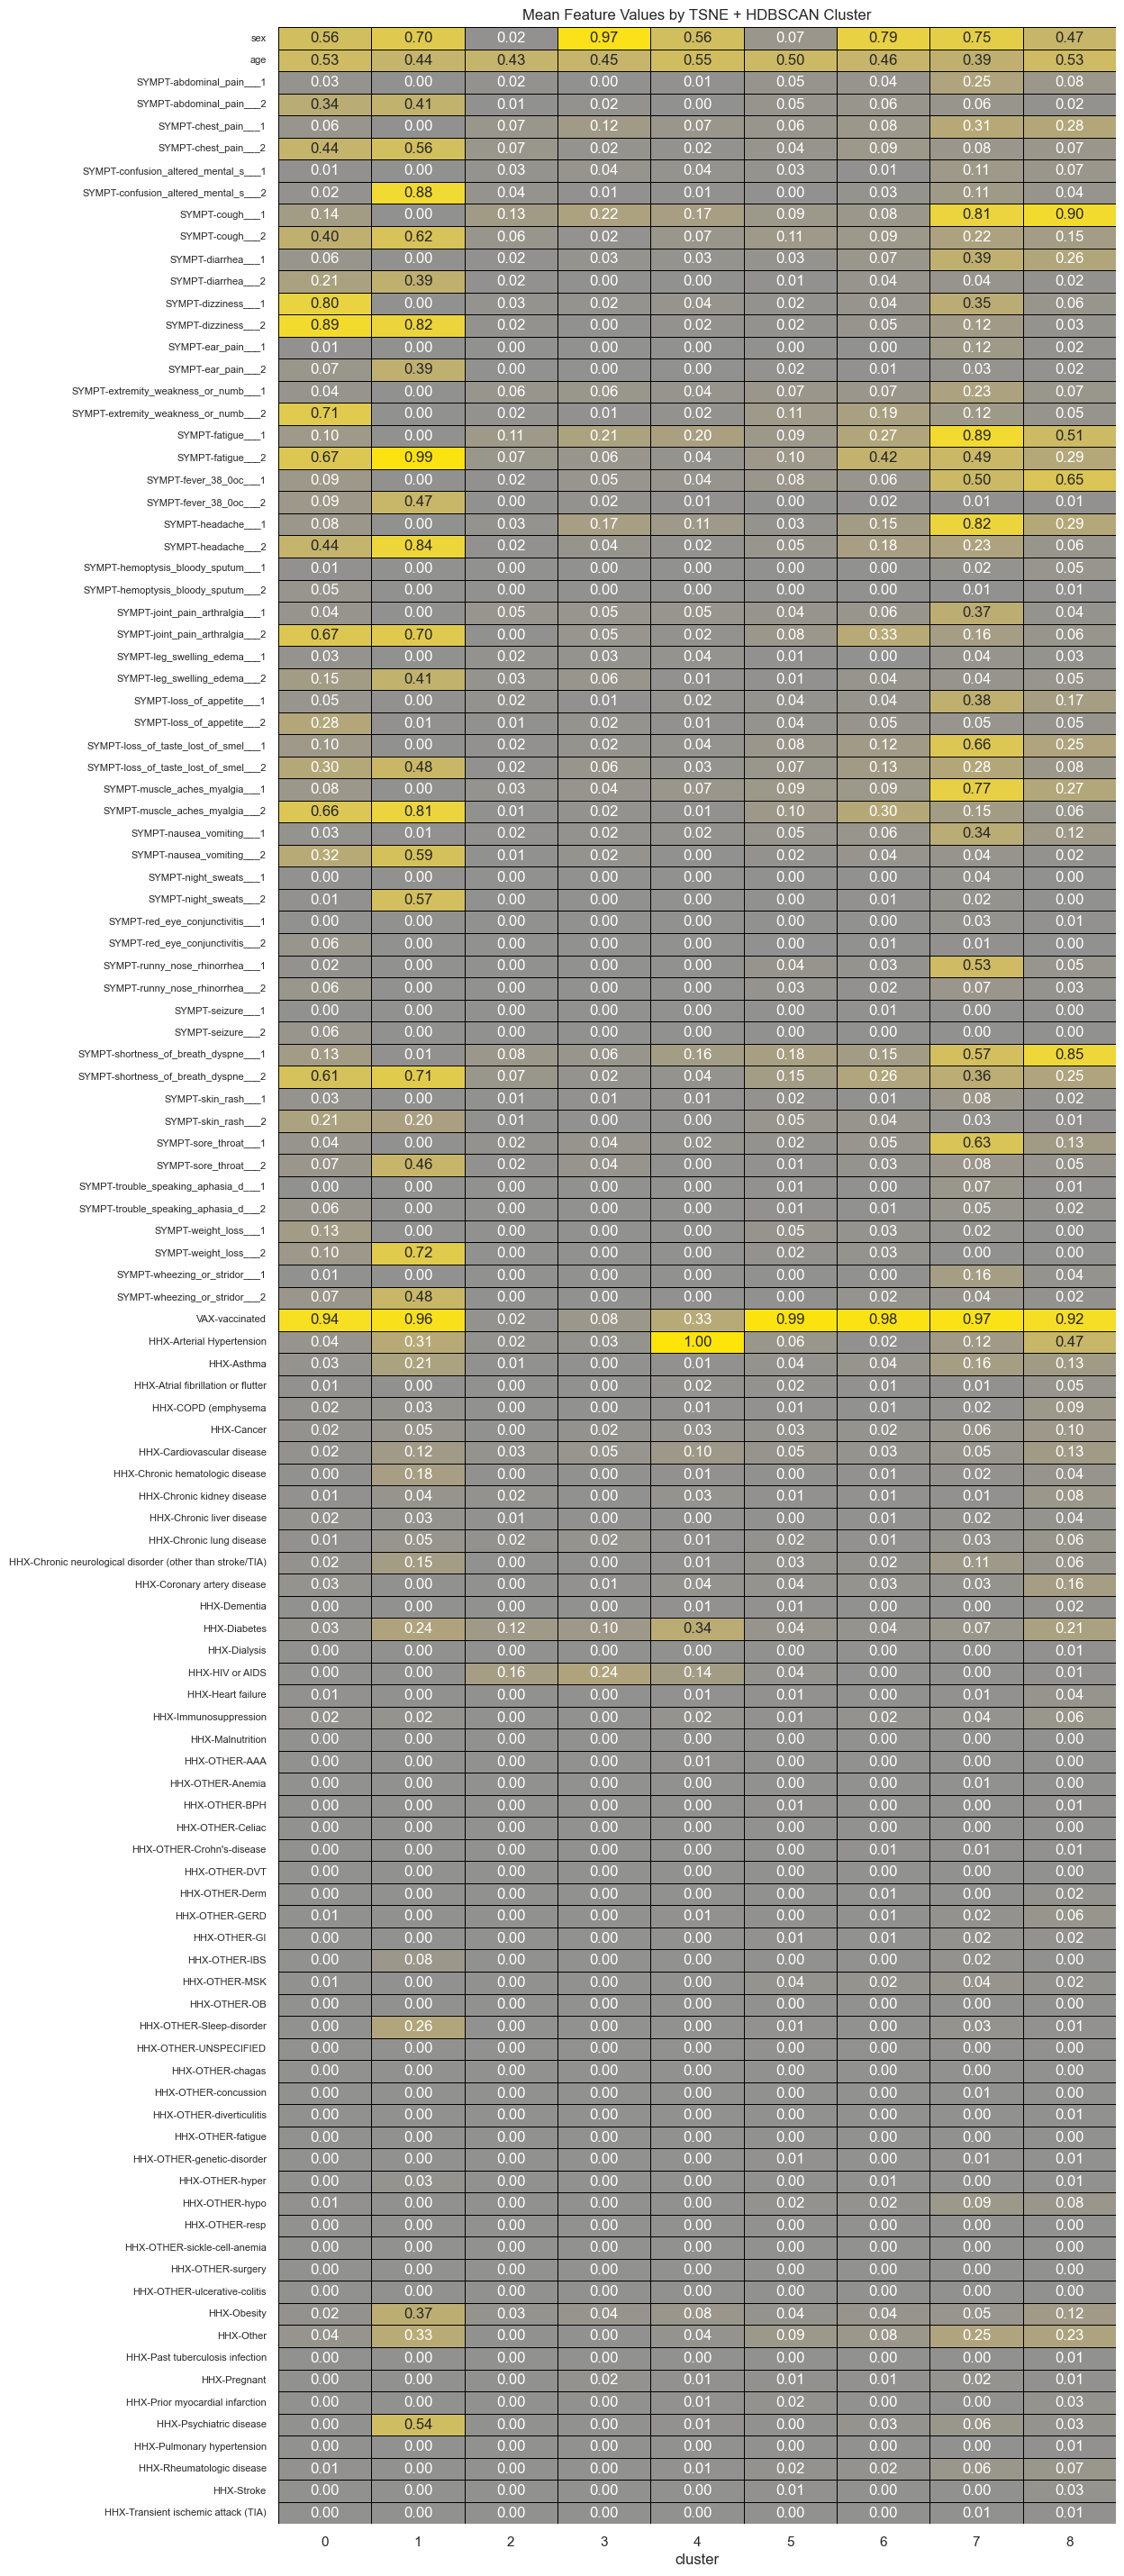

In [986]:
# heatmap of the means by cluster
fig, ax = plt.subplots(figsize=(12,36))

# apply lognorm to the colour scale
norm = mc.LogNorm(vmin = 0.01, vmax = 10.0)
norm = None

# get the means by cluster

# augment with cluster
XX["cluster"] = tsne_df["Most Likely Cluster"]

mm = XX.groupby("cluster").mean().T

# negative log transform
# mm = -np.log10(mm)

# sort mm in alphabetical order
# mm = mm.sort_index()

# use a diverging colour scheme
cmap = sns.diverging_palette(220, 20, as_cmap = True)

cmap = cc.cm.bjy

sns.heatmap(mm, ax = ax, cmap = cmap,norm = norm, **heatmap_parms)

plt.title("Mean Feature Values by TSNE + HDBSCAN Cluster")
# make font smaller
plt.yticks(fontsize = 8);
# plt.savefig('mean_feature_values.png', dpi = 300)

fn = "mean-feature-values-tsne.png"
p = f"{figdir}/{fn}"

plt.savefig(p, dpi = 300, bbox_inches = 'tight')


# TODO

- "feature importances" - what features discriminate between the clusters?